## XG Boost - User Level Data (No Data Leakage)

This notebook uses `user_level_data.csv` which is already aggregated at the user level, avoiding data leakage issues that may occur with impression-level data.


## 1) LOADING PACKAGES


In [45]:
# Core data manipulation and numerical computing
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report,
    precision_score, recall_score, f1_score, confusion_matrix,
    make_scorer
)

# XGBoost
import xgboost as xgb

# Optional: SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Note: SHAP not available. Install with 'pip install shap' for interpretability analysis.")

print("✓ All packages loaded successfully")


✓ All packages loaded successfully


## 2) LOADING DATASET

Using `user_level_data.csv` which is already aggregated at the user level, avoiding data leakage from using impression-level features.


In [46]:
print("\nLoading user-level data...")
df = pd.read_csv(Path("../data/user_level_data.csv"))
y = df["y_active"].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# Drop identifier columns and target variable
drop_cols = [c for c in ["y_active", "userId"] if c in df.columns]
X = df.drop(columns=drop_cols, errors="ignore")
print(f"Features after dropping identifiers: {X.shape[1]}")



Loading user-level data...
Dataset shape: (2413, 29)
Target distribution:
y_active
1    0.592209
0    0.407791
Name: proportion, dtype: float64
Features after dropping identifiers: 27


## 3) FEATURE ENGINEERING


In [47]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# === Interaction Features ===
# Using avg_pop_index_pca instead of pop_index_pca if available
if "usr_click_rate" in X.columns and "avg_pop_index_pca" in X.columns:
    X["usr_click_rate_x_pop"] = X["usr_click_rate"] * X["avg_pop_index_pca"]
    print("✓ Created: usr_click_rate_x_pop")

if "usr_action_types_taken" in X.columns and "usr_engagement_span" in X.columns:
    X["usr_action_diversity_x_span"] = X["usr_action_types_taken"] * X["usr_engagement_span"]
    print("✓ Created: usr_action_diversity_x_span")

if "usr_like_rate" in X.columns and "usr_click_rate" in X.columns:
    X["usr_like_per_click"] = X["usr_like_rate"] / (X["usr_click_rate"] + 1e-6)
    print("✓ Created: usr_like_per_click")

# === Engagement Score Features ===
engagement_cols = ["usr_click_rate", "usr_like_rate", "usr_share_rate", "usr_comment_rate"]
if all(col in X.columns for col in engagement_cols):
    X["usr_total_engagement_score"] = (
        X["usr_click_rate"] * 1.0 +
        X["usr_like_rate"] * 2.0 +
        X["usr_share_rate"] * 3.0 +
        X["usr_comment_rate"] * 3.0
    )
    print("✓ Created: usr_total_engagement_score")
    
    # Engagement diversity (coefficient of variation)
    engagement_std = X[engagement_cols].std(axis=1)
    engagement_mean = X[engagement_cols].mean(axis=1)
    X["usr_engagement_diversity"] = engagement_std / (engagement_mean + 1e-6)
    print("✓ Created: usr_engagement_diversity")

# === Activity Intensity Features ===
if "usr_total_impressions" in X.columns and "usr_active_days" in X.columns:
    X["usr_impressions_per_day"] = X["usr_total_impressions"] / (X["usr_active_days"] + 1)
    print("✓ Created: usr_impressions_per_day")
    
    # Activity consistency (lower std = more consistent)
    if "usr_weekend_share" in X.columns:
        X["usr_activity_consistency"] = 1 - abs(X["usr_weekend_share"] - 0.5) * 2  # Closer to 0.5 = more consistent
        print("✓ Created: usr_activity_consistency")

# === Social Engagement Features ===
if "avg_followCnt_log" in X.columns and "usr_share_rate" in X.columns:
    X["social_reach_x_sharing"] = X["avg_followCnt_log"] * X["usr_share_rate"]
    print("✓ Created: social_reach_x_sharing")
elif "usr_followlog_x_actionrate" in X.columns and "usr_share_rate" in X.columns:
    # Alternative if avg_followCnt_log not available
    X["social_reach_x_sharing"] = X["usr_followlog_x_actionrate"] * X["usr_share_rate"]
    print("✓ Created: social_reach_x_sharing (using usr_followlog_x_actionrate)")

if "usr_avg_dwell" in X.columns and "usr_click_rate" in X.columns:
    X["dwell_x_click_intensity"] = X["usr_avg_dwell"] * X["usr_click_rate"]
    print("✓ Created: dwell_x_click_intensity")

# === Additional User-Level Features ===
if "usr_total_impressions" in X.columns and "usr_engagement_span" in X.columns:
    X["usr_engagement_intensity"] = X["usr_total_impressions"] / (X["usr_engagement_span"] + 1)
    print("✓ Created: usr_engagement_intensity")

if "usr_action_types_taken" in X.columns and "usr_total_impressions" in X.columns:
    X["usr_action_diversity_per_impression"] = X["usr_action_types_taken"] / (X["usr_total_impressions"] + 1)
    print("✓ Created: usr_action_diversity_per_impression")

print(f"Total features after engineering: {X.shape[1]}")

print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

# === Low Variance Features ===
low_variance_cols = []
for col in X.select_dtypes(include=[np.number]).columns:
    if X[col].nunique() <= 2:
        if X[col].value_counts().iloc[0] / len(X) > 0.99:
            low_variance_cols.append(col)

if low_variance_cols:
    X = X.drop(columns=low_variance_cols, errors="ignore")
    print(f"Dropped {len(low_variance_cols)} low-variance features: {low_variance_cols}")

# === High Correlation Removal (after splits to avoid data leakage) ===
# This will be done after train/test split
print(f"Features after initial selection: {X.shape[1]}")



FEATURE ENGINEERING
✓ Created: usr_click_rate_x_pop
✓ Created: usr_like_per_click
✓ Created: usr_total_engagement_score
✓ Created: usr_engagement_diversity
✓ Created: usr_impressions_per_day
✓ Created: usr_activity_consistency
✓ Created: social_reach_x_sharing
✓ Created: dwell_x_click_intensity
✓ Created: usr_engagement_intensity
Total features after engineering: 36

FEATURE SELECTION
Dropped 1 low-variance features: ['usr_ever_clicked']
Features after initial selection: 35


## 4) DATA SPLITTING

Splitting at user level (data is already aggregated per user).


In [48]:
print("\n" + "="*60)
print("TRAIN/VALIDATION/TEST SPLITS (User-level)")
print("="*60)

# First split: 80% train+valid, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: 80% train, 20% valid (of the train_full set)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

print(f"Train: {X_train.shape[0]}, Valid: {X_valid.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train distribution: {y_train.value_counts(normalize=True).to_dict()}")



TRAIN/VALIDATION/TEST SPLITS (User-level)
Train: 1544, Valid: 386, Test: 483
Train distribution: {1: 0.5919689119170984, 0: 0.40803108808290156}


## 5) FEATURE PREPROCESSING


In [49]:
# === Remove Highly Correlated Features (on training set only) ===
print("\n" + "="*60)
print("CORRELATION-BASED FEATURE SELECTION")
print("="*60)

# Calculate correlation matrix for numerical features only
num_cols_for_corr = X_train.select_dtypes(include=[np.number]).columns
if len(num_cols_for_corr) > 1:
    corr_matrix = X_train[num_cols_for_corr].corr().abs()
    
    # Find pairs with correlation > 0.95
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    high_corr_pairs = corr_matrix.where(upper_triangle).stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]
    
    if len(high_corr_pairs) > 0:
        # Remove one feature from each highly correlated pair
        # Keep the feature with higher correlation to target
        to_remove = set()
        for (feat1, feat2), corr_val in high_corr_pairs.items():
            if feat1 not in to_remove and feat2 not in to_remove:
                # Check correlation with target
                corr1_target = abs(X_train[feat1].corr(y_train))
                corr2_target = abs(X_train[feat2].corr(y_train))
                # Remove the one with lower correlation to target
                if corr1_target < corr2_target:
                    to_remove.add(feat1)
                else:
                    to_remove.add(feat2)
        
        if to_remove:
            X_train = X_train.drop(columns=list(to_remove), errors="ignore")
            X_valid = X_valid.drop(columns=list(to_remove), errors="ignore")
            X_test = X_test.drop(columns=list(to_remove), errors="ignore")
            print(f"Removed {len(to_remove)} highly correlated features: {list(to_remove)[:10]}...")
    else:
        print("No highly correlated features found (threshold: 0.95)")

# Identify categorical and numerical features
cat_cols = list(X_train.select_dtypes(include=["object","category","string","bool"]).columns)
# Treat low-cardinality integer columns as categorical
for c in X_train.select_dtypes(include=["int16","int32","int64","Int8","Int16","Int32","Int64","uint8","uint16"]).columns:
    if X_train[c].nunique(dropna=True) <= 20 and c not in cat_cols:
        cat_cols.append(c)
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"\nCategorical features: {len(cat_cols)}")
print(f"Numerical features: {len(num_cols)}")

# Create preprocessing pipeline:
# - Numerical: Impute missing values with median
# - Categorical: Impute missing values with mode, then one-hot encode
print("\nFitting preprocessor...")
try:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)
except TypeError:
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh", oh_encoder)
        ]), cat_cols),
    ],
    remainder="drop"
)

X_train_t = pre.fit_transform(X_train, y_train)
X_valid_t = pre.transform(X_valid)
X_test_t  = pre.transform(X_test)

print(f"Transformed shapes - Train: {X_train_t.shape}, Valid: {X_valid_t.shape}, Test: {X_test_t.shape}")

oh = pre.named_transformers_["cat"].named_steps["oh"] if len(cat_cols) else None
cat_names = oh.get_feature_names_out(cat_cols) if oh is not None else np.array([])
num_names = np.array(num_cols)
feature_names = list(num_names) + list(cat_names)



CORRELATION-BASED FEATURE SELECTION
Removed 6 highly correlated features: ['usr_share_rate', 'usr_like_rate', 'usr_sum_share_follow', 'usr_sum_isShare_x_followlog', 'dwell_x_click_intensity', 'avg_pop_index_pca']...

Categorical features: 6
Numerical features: 23

Fitting preprocessor...
Transformed shapes - Train: (1544, 71), Valid: (386, 71), Test: (483, 71)


## 6) MODEL TRAINING


In [50]:
# Handle class imbalance by adjusting scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / max(pos, 1))

print(f"\nClass imbalance - Pos: {pos}, Neg: {neg}, Scale weight: {scale_pos_weight:.3f}")

# Convert to XGBoost's DMatrix format for efficient training
dtrain = xgb.DMatrix(X_train_t, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_t, label=y_valid, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test_t,  label=y_test, feature_names=feature_names)

# Optimized hyperparameters for better performance
# Notes:
# - learning_rate: 0.03 is conservative, good for generalization (can increase to 0.05-0.1 for speed)
# - max_depth: 5 prevents overfitting while capturing interactions
# - subsample & colsample: 0.85 provides regularization via row/column sampling
# - reg_alpha/lambda: L1/L2 regularization to prevent overfitting
# - min_child_weight: Higher value (2.0) requires more samples per leaf, more conservative
# - tree_method: "hist" is fast and memory-efficient for large datasets
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.03,          # Conservative learning rate for stability
    "max_depth": 5,                  # Moderate depth to balance complexity
    "subsample": 0.85,               # Row sampling for regularization
    "colsample_bytree": 0.85,        # Column sampling per tree
    "colsample_bylevel": 0.85,       # Column sampling per level
    "reg_alpha": 0.1,                # L1 regularization
    "reg_lambda": 2.0,               # L2 regularization (stronger)
    "min_child_weight": 2.0,         # Minimum samples per leaf
    "tree_method": "hist",           # Fast histogram-based method
    "scale_pos_weight": scale_pos_weight,  # Handle class imbalance
    "seed": 42,
}

print("\nTraining XGBoost model (optimized hyperparameters)...")
evals = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2500,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=50,
)

print(f"\nBest iteration: {booster.best_iteration}")
print(f"Best validation AUC: {booster.best_score:.4f}")



Class imbalance - Pos: 914, Neg: 630, Scale weight: 0.689

Training XGBoost model (optimized hyperparameters)...
[0]	train-auc:0.77549	valid-auc:0.70150
[50]	train-auc:0.85591	valid-auc:0.75240
[100]	train-auc:0.88035	valid-auc:0.74942
[149]	train-auc:0.89923	valid-auc:0.74859

Best iteration: 49
Best validation AUC: 0.7541


## 6.5) CROSS-VALIDATION (Optional Robustness Check)

Perform k-fold cross-validation to assess model stability across different data splits.


In [51]:
# Optional: Cross-validation for robustness assessment
print("\n" + "="*60)
print("CROSS-VALIDATION (5-Fold)")
print("="*60)

# Use training+validation set for CV
X_train_cv = np.vstack([X_train_t, X_valid_t])
y_train_cv = np.hstack([y_train.values, y_valid.values])

# Create CV folds
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_auc_scores = []
cv_pr_scores = []

print(f"Performing {cv_folds}-fold cross-validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cv, y_train_cv), 1):
    X_cv_train, X_cv_val = X_train_cv[train_idx], X_train_cv[val_idx]
    y_cv_train, y_cv_val = y_train_cv[train_idx], y_train_cv[val_idx]
    
    # Create DMatrix
    dtrain_cv = xgb.DMatrix(X_cv_train, label=y_cv_train)
    dval_cv = xgb.DMatrix(X_cv_val, label=y_cv_val)
    
    # Train model
    model_cv = xgb.train(
        params=params,
        dtrain=dtrain_cv,
        num_boost_round=booster.best_iteration,  # Use same number of trees as main model
        evals=[(dval_cv, "val")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )
    
    # Predict and evaluate
    y_pred_cv = model_cv.predict(dval_cv)
    auc_cv = roc_auc_score(y_cv_val, y_pred_cv)
    pr_cv = average_precision_score(y_cv_val, y_pred_cv)
    
    cv_auc_scores.append(auc_cv)
    cv_pr_scores.append(pr_cv)
    
    print(f"Fold {fold}: ROC AUC = {auc_cv:.4f}, PR AUC = {pr_cv:.4f}")

print(f"\nCross-Validation Results:")
print(f"ROC AUC: {np.mean(cv_auc_scores):.4f} (+/- {np.std(cv_auc_scores):.4f})")
print(f"PR AUC:  {np.mean(cv_pr_scores):.4f} (+/- {np.std(cv_pr_scores):.4f})")
print(f"\nCV Stability: {'Good' if np.std(cv_auc_scores) < 0.01 else 'Moderate' if np.std(cv_auc_scores) < 0.02 else 'Variable'}")



CROSS-VALIDATION (5-Fold)
Performing 5-fold cross-validation...
Fold 1: ROC AUC = 0.7498, PR AUC = 0.7930
Fold 2: ROC AUC = 0.7549, PR AUC = 0.8135
Fold 3: ROC AUC = 0.7500, PR AUC = 0.7970
Fold 4: ROC AUC = 0.7800, PR AUC = 0.8324
Fold 5: ROC AUC = 0.7409, PR AUC = 0.8033

Cross-Validation Results:
ROC AUC: 0.7551 (+/- 0.0133)
PR AUC:  0.8078 (+/- 0.0141)

CV Stability: Moderate


## 7) THRESHOLD OPTIMIZATION

The default threshold of 0.5 may not be optimal for our use case.
We optimize the threshold on the validation set to maximize F1-score, which balances precision and recall.


In [52]:
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

proba_valid = booster.predict(dvalid)
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = []
recall_scores = []
precision_scores = []
# Business-aligned metrics
# Assuming: False Negative (miss active user) costs 2x False Positive (waste intervention)
cost_fn_weight = 2.0  # Cost of missing an active user vs wasting intervention
business_scores = []

for threshold in thresholds:
    pred_valid = (proba_valid >= threshold).astype(int)
    f1_scores.append(f1_score(y_valid, pred_valid))
    recall_scores.append(recall_score(y_valid, pred_valid))
    precision_scores.append(precision_score(y_valid, pred_valid))
    
    # Business cost: minimize weighted cost
    tn, fp, fn, tp = confusion_matrix(y_valid, pred_valid).ravel()
    cost = fp + cost_fn_weight * fn  # FP cost = 1, FN cost = cost_fn_weight
    business_scores.append(-cost)  # Negative because we want to maximize (minimize cost)

# Find optimal thresholds for different metrics
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]
optimal_f1 = f1_scores[optimal_f1_idx]

optimal_precision_idx = np.argmax(precision_scores)
optimal_precision_threshold = thresholds[optimal_precision_idx]

optimal_recall_idx = np.argmax(recall_scores)
optimal_recall_threshold = thresholds[optimal_recall_idx]

optimal_business_idx = np.argmax(business_scores)
optimal_business_threshold = thresholds[optimal_business_idx]

# Youden's J statistic (maximize TPR - FPR)
# Calculate TPR and FPR directly from confusion matrix for each threshold
youden_scores = []
for threshold in thresholds:
    pred_valid = (proba_valid >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, pred_valid).ravel()
    tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    youden_scores.append(tpr_val - fpr_val)
optimal_youden_idx = np.argmax(youden_scores)
optimal_youden_threshold = thresholds[optimal_youden_idx]

print(f"Optimal threshold (F1): {optimal_f1_threshold:.3f} (F1: {optimal_f1:.4f})")
print(f"Optimal threshold (Precision): {optimal_precision_threshold:.3f} (Precision: {precision_scores[optimal_precision_idx]:.4f})")
print(f"Optimal threshold (Recall): {optimal_recall_threshold:.3f} (Recall: {recall_scores[optimal_recall_idx]:.4f})")
print(f"Optimal threshold (Business Cost, FN={cost_fn_weight}x): {optimal_business_threshold:.3f}")
print(f"Optimal threshold (Youden's J): {optimal_youden_threshold:.3f}")

default_idx = np.abs(thresholds - 0.5).argmin()
print(f"\nDefault threshold (0.5) - F1: {f1_scores[default_idx]:.4f}, "
      f"Recall: {recall_scores[default_idx]:.4f}, "
      f"Precision: {precision_scores[default_idx]:.4f}")

# Use F1-optimal as default, but store all for comparison
optimal_threshold = optimal_f1_threshold



THRESHOLD OPTIMIZATION
Optimal threshold (F1): 0.320 (F1: 0.7816)
Optimal threshold (Precision): 0.800 (Precision: 0.8806)
Optimal threshold (Recall): 0.200 (Recall: 0.9607)
Optimal threshold (Business Cost, FN=2.0x): 0.320
Optimal threshold (Youden's J): 0.440

Default threshold (0.5) - F1: 0.7136, Recall: 0.6638, Precision: 0.7716


## 8) MODEL EVALUATION

Evaluate on the held-out test set using both default (0.5) and optimal thresholds.


In [53]:
proba = booster.predict(dtest)
pred_default = (proba >= 0.5).astype(int)
pred_optimal = (proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

# === User-level Metrics ===
print("\n--- Default Threshold (0.5) ---")
roc_auc_default = roc_auc_score(y_test, proba)
pr_auc_default = average_precision_score(y_test, proba)
print(f"Hold-out ROC AUC: {round(roc_auc_default, 4)}")
print(f"Hold-out PR  AUC: {round(pr_auc_default, 4)}")
print(f"\nClassification report:\n{classification_report(y_test, pred_default, digits=3)}")

print(f"\n--- Optimal Threshold ({optimal_threshold:.3f}, F1-optimized) ---")
roc_auc_optimal = roc_auc_score(y_test, proba)
pr_auc_optimal = average_precision_score(y_test, proba)
print(f"Hold-out ROC AUC: {round(roc_auc_optimal, 4)}")
print(f"Hold-out PR  AUC: {round(pr_auc_optimal, 4)}")
print(f"\nClassification report:\n{classification_report(y_test, pred_optimal, digits=3)}")

cm_default = confusion_matrix(y_test, pred_default)
cm_optimal = confusion_matrix(y_test, pred_optimal)

print(f"\nConfusion Matrix (Threshold=0.5):\n{cm_default}")
print(f"\nConfusion Matrix (Threshold={optimal_threshold:.3f}):\n{cm_optimal}")

# === Business Metrics ===
print("\n" + "="*60)
print("BUSINESS METRICS")
print("="*60)

def calculate_business_metrics(y_true, y_pred, proba, cost_fn_weight=2.0):
    """Calculate business-aligned metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics = {
        'True Positives (TP)': tp,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp,
        'False Negatives (FN)': fn,
        'Total Cost (FP + {}xFN)'.format(cost_fn_weight): fp + cost_fn_weight * fn,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall (Sensitivity)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1-Score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
    }
    return metrics

print("\n--- Default Threshold (0.5) ---")
business_metrics_default = calculate_business_metrics(y_test, pred_default, proba, cost_fn_weight)
for metric, value in business_metrics_default.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

print(f"\n--- Optimal Threshold ({optimal_threshold:.3f}) ---")
business_metrics_optimal = calculate_business_metrics(y_test, pred_optimal, proba, cost_fn_weight)
for metric, value in business_metrics_optimal.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")



TEST SET PERFORMANCE

--- Default Threshold (0.5) ---
Hold-out ROC AUC: 0.7235
Hold-out PR  AUC: 0.7959

Classification report:
              precision    recall  f1-score   support

           0      0.577     0.629     0.602       197
           1      0.728     0.682     0.704       286

    accuracy                          0.660       483
   macro avg      0.652     0.656     0.653       483
weighted avg      0.666     0.660     0.662       483


--- Optimal Threshold (0.320, F1-optimized) ---
Hold-out ROC AUC: 0.7235
Hold-out PR  AUC: 0.7959

Classification report:
              precision    recall  f1-score   support

           0      0.655     0.386     0.486       197
           1      0.670     0.860     0.753       286

    accuracy                          0.667       483
   macro avg      0.663     0.623     0.620       483
weighted avg      0.664     0.667     0.644       483


Confusion Matrix (Threshold=0.5):
[[124  73]
 [ 91 195]]

Confusion Matrix (Threshold=0.320):

## 9) VISUALIZATIONS & FEATURE IMPORTANCE


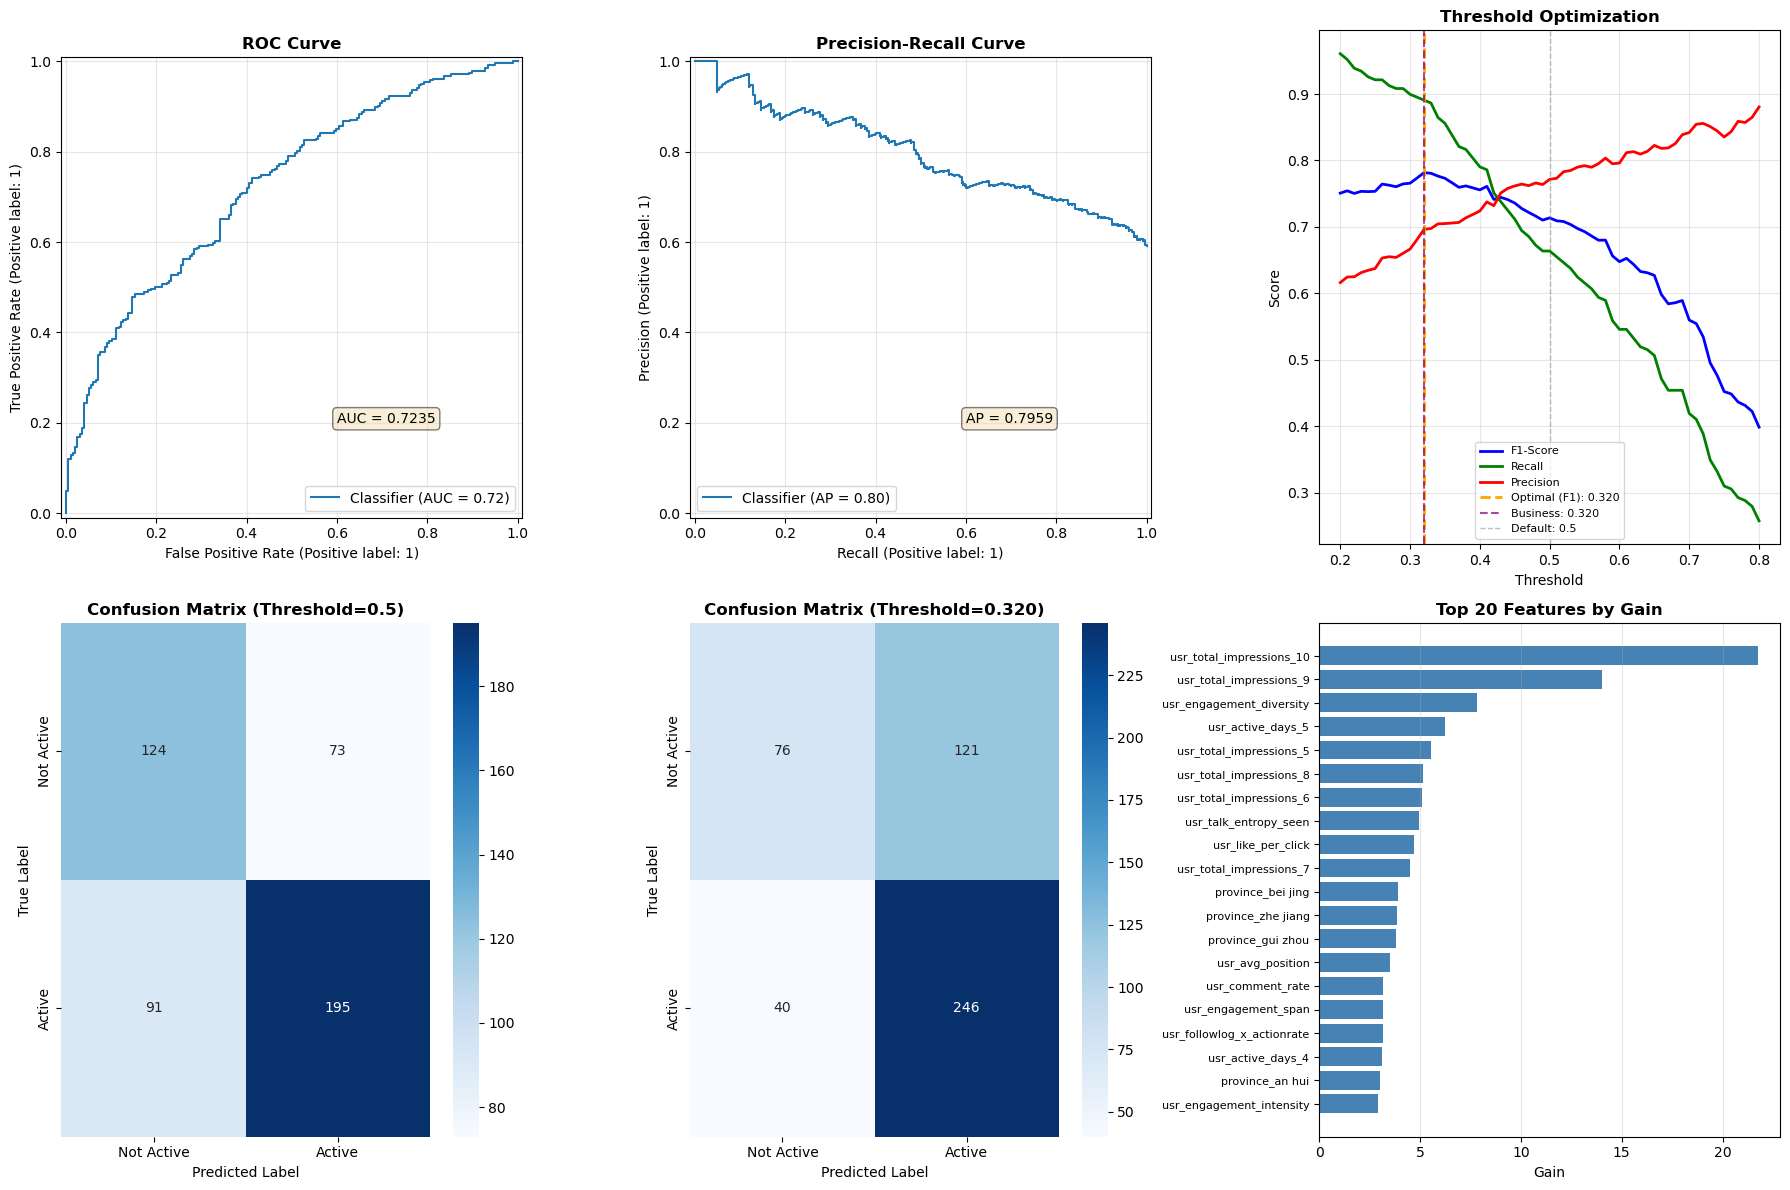


TOP 20 FEATURES BY GAIN
                   feature      gain
  usr_total_impressions_10 21.763229
   usr_total_impressions_9 14.012638
  usr_engagement_diversity  7.806911
         usr_active_days_5  6.239840
   usr_total_impressions_5  5.558092
   usr_total_impressions_8  5.138124
   usr_total_impressions_6  5.097228
     usr_talk_entropy_seen  4.966260
        usr_like_per_click  4.696849
   usr_total_impressions_7  4.514573
         province_bei jing  3.920126
        province_zhe jiang  3.861711
         province_gui zhou  3.826077
          usr_avg_position  3.493169
          usr_comment_rate  3.170506
       usr_engagement_span  3.166179
usr_followlog_x_actionrate  3.153804
         usr_active_days_4  3.126195
           province_an hui  3.031892
  usr_engagement_intensity  2.910500


Bottom 10% features (consider dropping if not needed):
               feature     gain
social_reach_x_sharing 1.061963
     province_si chuan 1.283750
       province_he bei 1.472683
     usr_acti

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

RocCurveDisplay.from_predictions(y_test, proba, ax=axes[0, 0])
axes[0, 0].set_title("ROC Curve", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.6, 0.2, f'AUC = {roc_auc_optimal:.4f}', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

PrecisionRecallDisplay.from_predictions(y_test, proba, ax=axes[0, 1])
axes[0, 1].set_title("Precision-Recall Curve", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.6, 0.2, f'AP = {pr_auc_optimal:.4f}', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0, 2].plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1-Score')
axes[0, 2].plot(thresholds, recall_scores, 'g-', linewidth=2, label='Recall')
axes[0, 2].plot(thresholds, precision_scores, 'r-', linewidth=2, label='Precision')
axes[0, 2].axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal (F1): {optimal_threshold:.3f}')
# Ensure optimal_business_threshold is defined
try:
    _ = optimal_business_threshold
except NameError:
    optimal_business_threshold = optimal_threshold  # Fallback to F1-optimal
axes[0, 2].axvline(x=optimal_business_threshold, color='purple', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Business: {optimal_business_threshold:.3f}')
axes[0, 2].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Default: 0.5')
axes[0, 2].set_xlabel('Threshold', fontsize=10)
axes[0, 2].set_ylabel('Score', fontsize=10)
axes[0, 2].set_title('Threshold Optimization', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Not Active', 'Active'], yticklabels=['Not Active', 'Active'])
axes[1, 0].set_title(f"Confusion Matrix (Threshold=0.5)", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Not Active', 'Active'], yticklabels=['Not Active', 'Active'])
axes[1, 1].set_title(f"Confusion Matrix (Threshold={optimal_threshold:.3f})", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

score = booster.get_score(importance_type="gain")
if score:
    imp_dict = {}
    for k, v in score.items():
        if k.startswith("f") and len(k) > 1 and k[1:].isdigit():
            idx = int(k[1:])
            if idx < len(feature_names):
                imp_dict[feature_names[idx]] = v
        else:
            imp_dict[k] = v
    
    imp = pd.DataFrame({
        "feature": list(imp_dict.keys()),
        "gain": list(imp_dict.values())
    }).sort_values("gain", ascending=False).head(20)
    
    axes[1, 2].barh(range(len(imp)), imp["gain"].values, color='steelblue')
    axes[1, 2].set_yticks(range(len(imp)))
    axes[1, 2].set_yticklabels(imp["feature"].values, fontsize=8)
    axes[1, 2].set_xlabel("Gain", fontsize=10)
    axes[1, 2].set_title("Top 20 Features by Gain", fontsize=12, fontweight='bold')
    axes[1, 2].invert_yaxis()
    axes[1, 2].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 2].text(0.5, 0.5, "No feature importance available", 
                    ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title("Feature Importance", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

if score:
    print("\n" + "="*60)
    print("TOP 20 FEATURES BY GAIN")
    print("="*60)
    print(imp.to_string(index=False))
    
    all_imp = pd.DataFrame({
        "feature": list(imp_dict.keys()),
        "gain": list(imp_dict.values())
    }).sort_values("gain", ascending=True)
    
    bottom_10_pct = int(len(all_imp) * 0.1)
    low_importance = all_imp.head(bottom_10_pct)
    
    print(f"\n\nBottom 10% features (consider dropping if not needed):")
    print(low_importance.to_string(index=False))


## 10) MODEL INTERPRETABILITY WITH SHAP

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and show how each feature contributes to individual predictions.


SHAP library available. Computing SHAP values...

Generating SHAP summary plot...


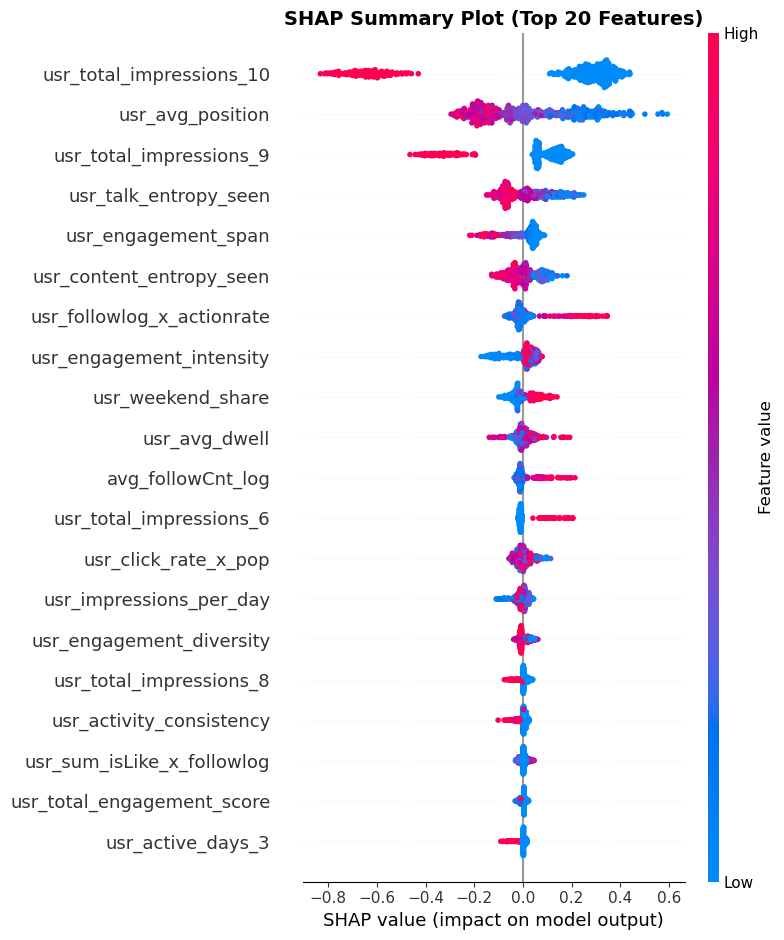


TOP 20 FEATURES BY SHAP IMPORTANCE
                   feature  shap_importance
  usr_total_impressions_10         0.391150
          usr_avg_position         0.165523
   usr_total_impressions_9         0.157285
     usr_talk_entropy_seen         0.076051
       usr_engagement_span         0.056446
  usr_content_entropy_seen         0.045570
usr_followlog_x_actionrate         0.045373
  usr_engagement_intensity         0.042433
         usr_weekend_share         0.036780
             usr_avg_dwell         0.025070
         avg_followCnt_log         0.024164
   usr_total_impressions_6         0.022662
      usr_click_rate_x_pop         0.020779
   usr_impressions_per_day         0.016784
  usr_engagement_diversity         0.014122
   usr_total_impressions_8         0.011978
  usr_activity_consistency         0.011160
usr_sum_isLike_x_followlog         0.009893
usr_total_engagement_score         0.008947
         usr_active_days_3         0.008232

Generating SHAP waterfall plot for exam

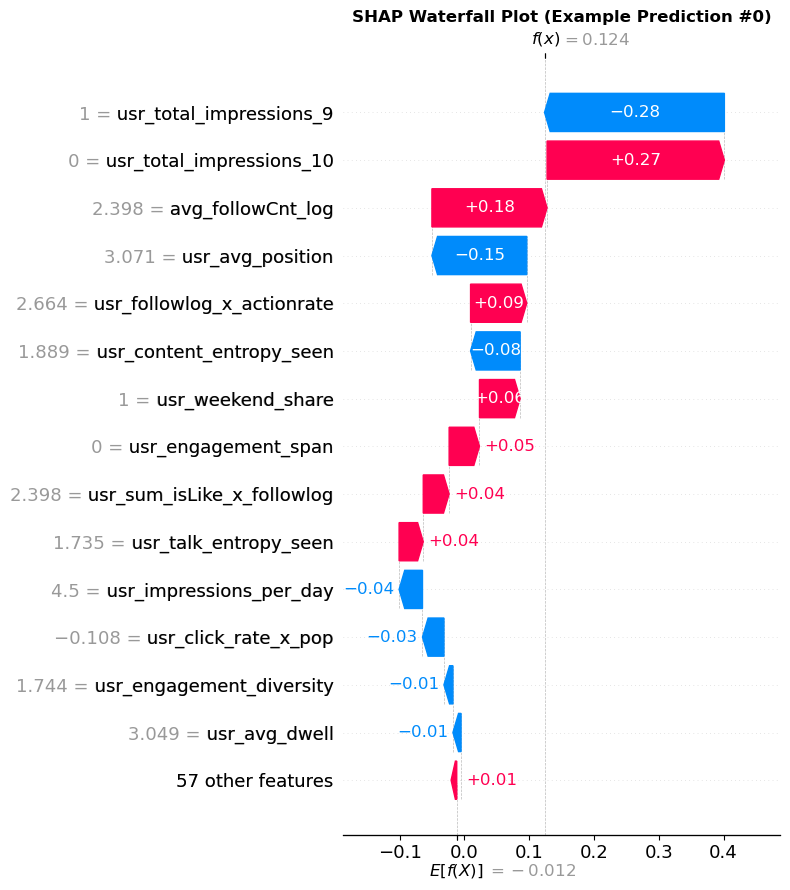

In [55]:
# SHAP values for model interpretability
try:
    import shap
    print("SHAP library available. Computing SHAP values...")
    
    # Create a small sample for SHAP (SHAP can be slow on large datasets)
    sample_size = min(1000, len(X_test_t))
    sample_indices = np.random.choice(len(X_test_t), sample_size, replace=False)
    X_test_sample = X_test_t[sample_indices]
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_test_sample)
    
    # Summary plot
    print("\nGenerating SHAP summary plot...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                     max_display=20, show=False)
    plt.title("SHAP Summary Plot (Top 20 Features)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': np.abs(shap_values).mean(0)
    }).sort_values('shap_importance', ascending=False)
    
    print("\n" + "="*60)
    print("TOP 20 FEATURES BY SHAP IMPORTANCE")
    print("="*60)
    print(shap_importance.head(20).to_string(index=False))
    
    # Waterfall plot for a single prediction (example)
    print("\nGenerating SHAP waterfall plot for example prediction...")
    example_idx = 0
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[example_idx],
        base_values=explainer.expected_value,
        data=X_test_sample[example_idx],
        feature_names=feature_names
    ), max_display=15, show=False)
    plt.title(f"SHAP Waterfall Plot (Example Prediction #{example_idx})", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("SHAP library not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"SHAP analysis encountered an error: {e}")
    print("Continuing without SHAP values...")
